# Part 3.3

Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biL-STM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible

Comparison between the models : 
+ (+)RNNs process data in a sequential manner (one direction); they retain information from previous steps but can struggle to remember distant information due to issues like vanishing gradients.
- (-)RNNs fail to capture long-term dependencies, especially in long sequences, as the information fades over time, and gradients vanish during backpropagation through time. Limits effectiveness in tasks requiring model to remember information over many time steps.
-----------------------------------------------
- (+)BiLSTM : Bidirectional Long Short-Term Memory, a RNN, handle long term dependencies better. It has gates that help regulate flow of information, enabling them to retain or discard information as needed.

- BiLSTM consists of 2 LSTM layers running in opposite directions : 1 processes sequence from past to future, while other processes it from future to past : captures both past and future context for each time step 

- BiLSTM helps to capture context from both directions, beneficial in tasks where understanding context of each word is important

- (-) BiLSTMs are computationally more intensive than regular LSTMs and RNNs due to bidirectional component and complexity of gating mechanism
-----------------------------------------------
- (+)BiGRU, type of RNN, has 2 gates instead of 3 used by LSTMS - makes GRUs faster to computer while still handling long-term dependencies better than traditional RNNs. Includes 2 GRU layers, one running forward one running backward, learnign both past and present context. 

- BiGRUs achieve similar performance to BiLSTMs but with fewer parameters and faster computation, making them more efficient for large datasets 

- (-)Although GRUs generally simpler and faster, might be less expressive in certain cases due to absence of output gate

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data preparation

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

In [7]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# biL-STM model

In [8]:
MODEL_TYPE = "lstm"
LR = 0.0001

## 2 layers

In [9]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [10]:
# training with mean max pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6929, Accuracy: 0.5263
Model saved.
Epoch   2/100, Loss: 0.6845, Accuracy: 0.5722
Model saved.
Epoch   3/100, Loss: 0.6631, Accuracy: 0.6004
Model saved.
Epoch   4/100, Loss: 0.6446, Accuracy: 0.5826
Epoch   5/100, Loss: 0.6288, Accuracy: 0.5919
Epoch   6/100, Loss: 0.6197, Accuracy: 0.5957
Epoch   7/100, Loss: 0.6044, Accuracy: 0.6013
Model saved.
Epoch   8/100, Loss: 0.5945, Accuracy: 0.6004
Epoch   9/100, Loss: 0.5829, Accuracy: 0.6135
Model saved.
Epoch  10/100, Loss: 0.5738, Accuracy: 0.6154
Model saved.
Epoch  11/100, Loss: 0.5596, Accuracy: 0.6060
Epoch  12/100, Loss: 0.5495, Accuracy: 0.6098
Epoch  13/100, Loss: 0.5341, Accuracy: 0.6144
Epoch  14/100, Loss: 0.5180, Accuracy: 0.6135
Epoch  15/100, Loss: 0.4990, Accuracy: 0.6220
Model saved.
Epoch  16/100, Loss: 0.4841, Accuracy: 0.6191
Epoch  17/100, Loss: 0.4664, Accuracy: 0.6182
Epoch  18/100, Loss: 0.4392, Accuracy: 0.6257
Model saved.
Epoch  19/100, Loss: 0.4195, Accuracy: 0.6182
Epoch  20/100, Loss: 0

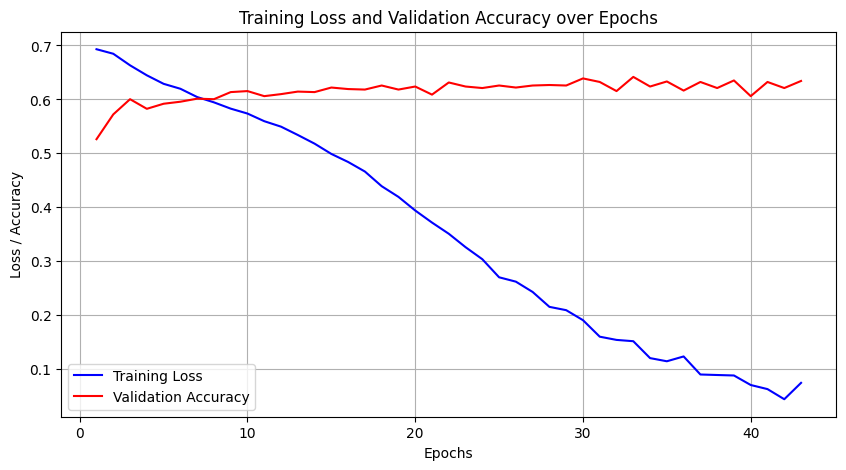

In [11]:
plot_loss_accuracy(losses, accuracies)

In [12]:
lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6435


## 4 layers

Trying with an increased number of stack layers

In [13]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # increased to 4 for stacking multiple layers
)

In [14]:
# training with mean max pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6932, Accuracy: 0.5000
Model saved.
Epoch   2/100, Loss: 0.6791, Accuracy: 0.5769
Model saved.
Epoch   3/100, Loss: 0.6534, Accuracy: 0.5957
Model saved.
Epoch   4/100, Loss: 0.6362, Accuracy: 0.5966
Model saved.
Epoch   5/100, Loss: 0.6252, Accuracy: 0.5872
Epoch   6/100, Loss: 0.6112, Accuracy: 0.5994
Model saved.
Epoch   7/100, Loss: 0.5993, Accuracy: 0.5994
Epoch   8/100, Loss: 0.5891, Accuracy: 0.6069
Model saved.
Epoch   9/100, Loss: 0.5757, Accuracy: 0.5891
Epoch  10/100, Loss: 0.5680, Accuracy: 0.6248
Model saved.
Epoch  11/100, Loss: 0.5507, Accuracy: 0.6079
Epoch  12/100, Loss: 0.5345, Accuracy: 0.6004
Epoch  13/100, Loss: 0.5146, Accuracy: 0.6041
Epoch  14/100, Loss: 0.4953, Accuracy: 0.6276
Model saved.
Epoch  15/100, Loss: 0.4734, Accuracy: 0.6154
Epoch  16/100, Loss: 0.4603, Accuracy: 0.6079
Epoch  17/100, Loss: 0.4299, Accuracy: 0.6041
Epoch  18/100, Loss: 0.4142, Accuracy: 0.6210
Epoch  19/100, Loss: 0.3889, Accuracy: 0.6107
Epoch  20/100, Loss: 0

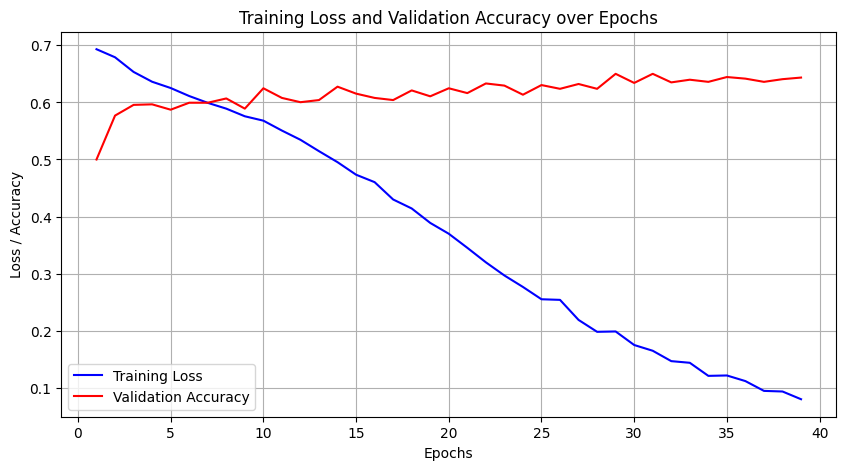

In [15]:
plot_loss_accuracy(losses, accuracies)

In [16]:
lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6492


# biGRU model

In [17]:
MODEL_TYPE = "gru"
LR = 0.0001

## 2 layers

In [18]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [19]:
# training with mean max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6919, Accuracy: 0.5375
Model saved.
Epoch   2/100, Loss: 0.6772, Accuracy: 0.5666
Model saved.
Epoch   3/100, Loss: 0.6564, Accuracy: 0.5919
Model saved.
Epoch   4/100, Loss: 0.6425, Accuracy: 0.6013
Model saved.
Epoch   5/100, Loss: 0.6302, Accuracy: 0.5929
Epoch   6/100, Loss: 0.6178, Accuracy: 0.5882
Epoch   7/100, Loss: 0.6055, Accuracy: 0.5910
Epoch   8/100, Loss: 0.5940, Accuracy: 0.6041
Model saved.
Epoch   9/100, Loss: 0.5839, Accuracy: 0.5797
Epoch  10/100, Loss: 0.5734, Accuracy: 0.5769
Epoch  11/100, Loss: 0.5613, Accuracy: 0.5816
Epoch  12/100, Loss: 0.5508, Accuracy: 0.5797
Epoch  13/100, Loss: 0.5408, Accuracy: 0.5882
Epoch  14/100, Loss: 0.5260, Accuracy: 0.5844
Epoch  15/100, Loss: 0.5088, Accuracy: 0.5844
Epoch  16/100, Loss: 0.4919, Accuracy: 0.5882
Epoch  17/100, Loss: 0.4731, Accuracy: 0.5910
Epoch  18/100, Loss: 0.4561, Accuracy: 0.5835
Early stopping triggered after 18 epochs.
Training ended, loading best model...
Model loaded.


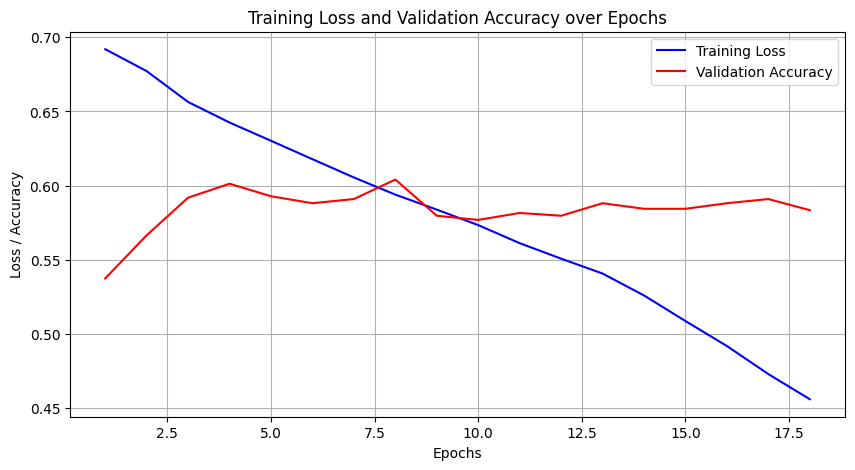

In [20]:
plot_loss_accuracy(losses, accuracies)

In [21]:
gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6379


## 4 layers

Trying with an increased number of stack layers

In [22]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # increased to 4 for stacking multiple layers
)

In [23]:
# training with mean max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6914, Accuracy: 0.5629
Model saved.
Epoch   2/100, Loss: 0.6716, Accuracy: 0.5863
Model saved.
Epoch   3/100, Loss: 0.6483, Accuracy: 0.5891
Model saved.
Epoch   4/100, Loss: 0.6322, Accuracy: 0.5882
Epoch   5/100, Loss: 0.6216, Accuracy: 0.5835
Epoch   6/100, Loss: 0.6085, Accuracy: 0.5938
Model saved.
Epoch   7/100, Loss: 0.5959, Accuracy: 0.5835
Epoch   8/100, Loss: 0.5851, Accuracy: 0.5844
Epoch   9/100, Loss: 0.5758, Accuracy: 0.5863
Epoch  10/100, Loss: 0.5673, Accuracy: 0.5816
Epoch  11/100, Loss: 0.5530, Accuracy: 0.5797
Epoch  12/100, Loss: 0.5366, Accuracy: 0.5919
Epoch  13/100, Loss: 0.5240, Accuracy: 0.5966
Model saved.
Epoch  14/100, Loss: 0.5066, Accuracy: 0.5779
Epoch  15/100, Loss: 0.4883, Accuracy: 0.5966
Epoch  16/100, Loss: 0.4681, Accuracy: 0.5929
Epoch  17/100, Loss: 0.4446, Accuracy: 0.5966
Epoch  18/100, Loss: 0.4178, Accuracy: 0.6191
Model saved.
Epoch  19/100, Loss: 0.3964, Accuracy: 0.6051
Epoch  20/100, Loss: 0.3716, Accuracy: 0.6060
Ep

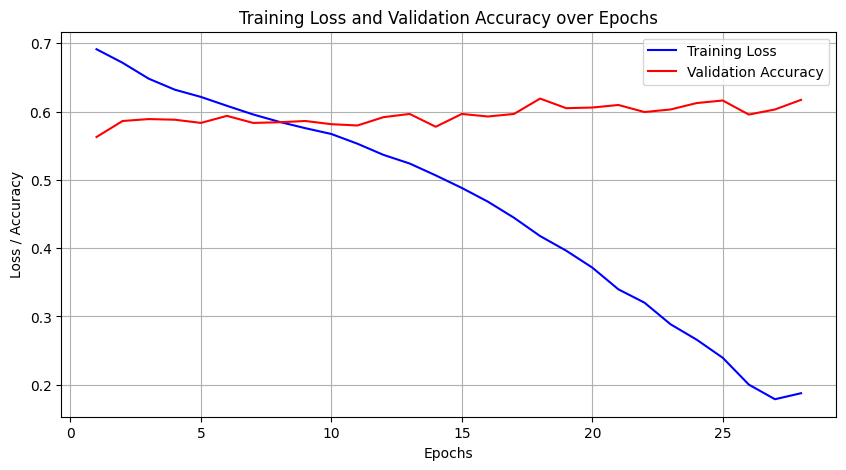

In [24]:
plot_loss_accuracy(losses, accuracies)

In [25]:
gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6379


# Results

In [26]:
print(f"2 layer biL-STM Test Accuracy:  {lstm_2_accuracy:.4f}")
print(f"4 layer biL-STM Test Accuracy:  {lstm_4_accuracy:.4f}")
print(f"2 layer bi-GRU Test Accuracy:   {gru_2_accuracy:.4f}")
print(f"4 layer bi-GRU Test Accuracy:   {gru_4_accuracy:.4f}")

2 layer biL-STM Test Accuracy:  0.6435
4 layer biL-STM Test Accuracy:  0.6492
2 layer bi-GRU Test Accuracy:   0.6379
4 layer bi-GRU Test Accuracy:   0.6379


the accuracy is not as good as we expected it to be, still needs refinement